# MIR

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import MIR
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 5
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = f"class_saturation/{N_EXPERIENCES}"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/mir.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

In [8]:
best_hyperparameters = {
    'mem_size': 50,
    'subsample': 5
}

## Evaluation metrics definition

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [10]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [11]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = MIR(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    batch_size_mem=128,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/5 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 114.92it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 110.4000
	Loss_MB/train_phase/train_stream/Task000 = 1.2284
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 4.0818
100%|██████████| 469/469 [00:04<00:00, 115.85it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.7000
	Loss_MB/train_phase/train_stream/Task000 = 0.7185
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0485
100%|██████████| 469/469 [00:04<00:00, 115.78it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.5801
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0509
100%|██████████| 469/469 [00:03<00:00, 117.42it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 20%|██        | 1/5 [00:25<01:41, 25.44s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0201
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1739a3fd0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1329.6279
	EvalStream/Acc_Matrix = 
tensor([[0.9149, 0.1221, 0.1583, 0.1508, 0.1223],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 2.2544
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 390.0781
	StreamBWT/eval_phase/test_stream = 0.0000
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2937
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.2192
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

 40%|████      | 2/5 [00:51<01:16, 25.62s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 103.9324
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17f4b55e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1329.6279
	EvalStream/Acc_Matrix = 
tensor([[0.9149, 0.1221, 0.1583, 0.1508, 0.1223],
        [0.9000, 0.9286, 0.1776, 0.1194, 0.1533],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8255
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 372.7969
	StreamBWT/eval_phase/test_stream = -0.0149
	StreamForgetting/eval_phase/test_stream = 0.0149
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4558
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.4167
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

 60%|██████    | 3/5 [01:17<00:52, 26.10s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.2105
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17b707f70>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1329.6279
	EvalStream/Acc_Matrix = 
tensor([[0.9149, 0.1221, 0.1583, 0.1508, 0.1223],
        [0.9000, 0.9286, 0.1776, 0.1194, 0.1533],
        [0.8785, 0.8988, 0.9324, 0.1019, 0.1285],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.5313
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 189.9844
	StreamBWT/eval_phase/test_stream = -0.0331
	StreamForgetting/eval_phase/test_stream = 0.0331
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5880
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.5876
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

 80%|████████  | 4/5 [01:45<00:26, 26.73s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 103.8771
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17fb548e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1329.6279
	EvalStream/Acc_Matrix = 
tensor([[0.9149, 0.1221, 0.1583, 0.1508, 0.1223],
        [0.9000, 0.9286, 0.1776, 0.1194, 0.1533],
        [0.8785, 0.8988, 0.9324, 0.1019, 0.1285],
        [0.8251, 0.8734, 0.9156, 0.9357, 0.1082],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.9286
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 367.3281
	StreamBWT/eval_phase/test_stream = -0.0539
	StreamForgetting/eval_phase/test_stream = 0.0539
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7316
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.7790
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

100%|██████████| 5/5 [02:12<00:00, 26.42s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.2819
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17eefc430>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1329.6279
	EvalStream/Acc_Matrix = 
tensor([[0.9149, 0.1221, 0.1583, 0.1508, 0.1223],
        [0.9000, 0.9286, 0.1776, 0.1194, 0.1533],
        [0.8785, 0.8988, 0.9324, 0.1019, 0.1285],
        [0.8251, 0.8734, 0.9156, 0.9357, 0.1082],
        [0.8087, 0.8474, 0.8943, 0.9132, 0.9402]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.3789
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 215.0469
	StreamBWT/eval_phase/test_stream = -0.0620
	StreamForgetting/eval_phase/test_stream = 0.0620
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8808
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.9592
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

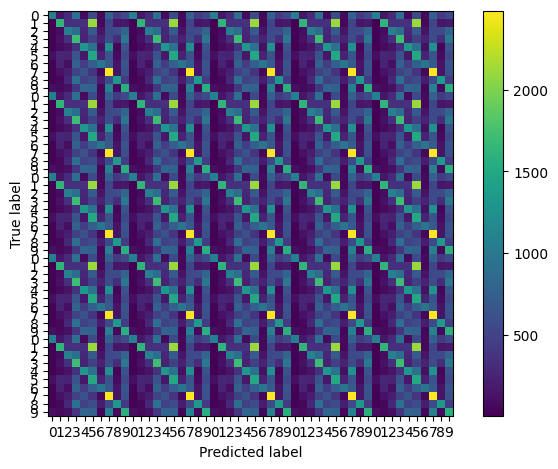

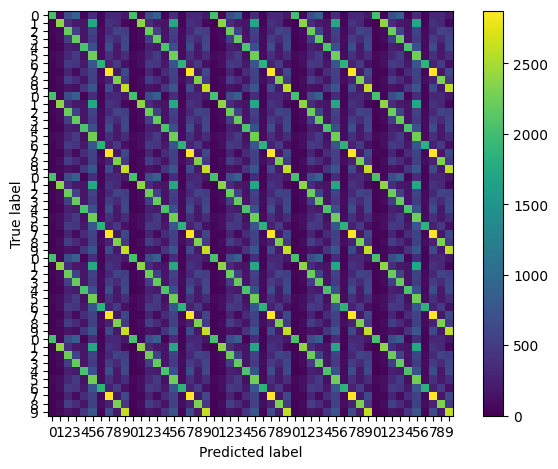

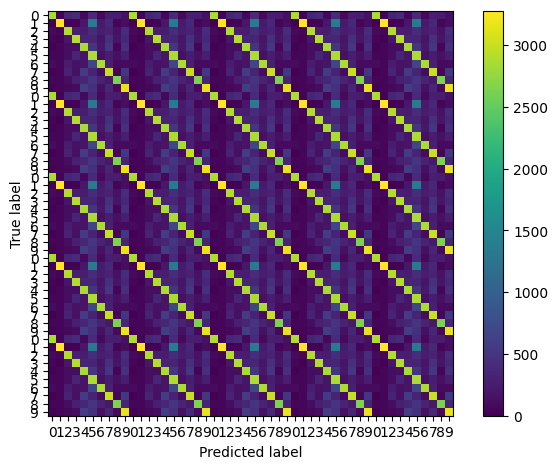

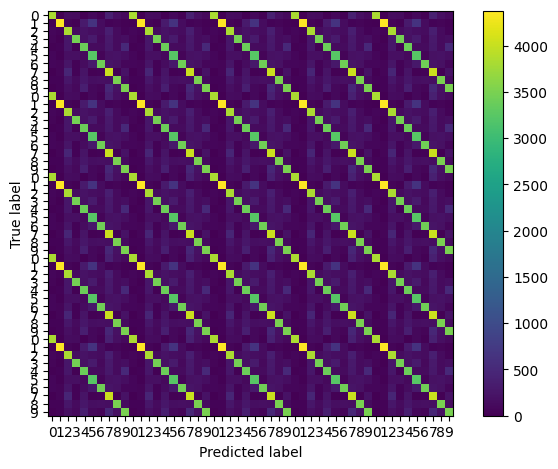

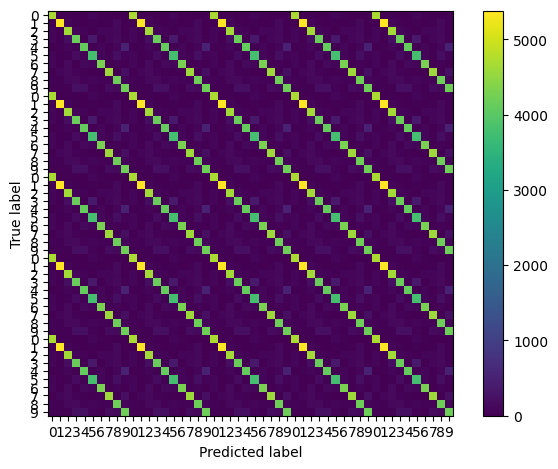

In [12]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [13]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [14]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [15]:
weights = model_plugins[0].weights

# Store metrics

In [16]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))